In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 
import ast
import re

In [ ]:
# Charger le nouveau dataset
recipe = pd.read_csv("recipe/4_recipe_minutes_category.csv")
print(recipe.columns)
print(recipe.shape)

Index(['id', 'n_ingredients', 'n_steps', 'minutes', 'steps'], dtype='object')
(221814, 5)


Variable n_steps

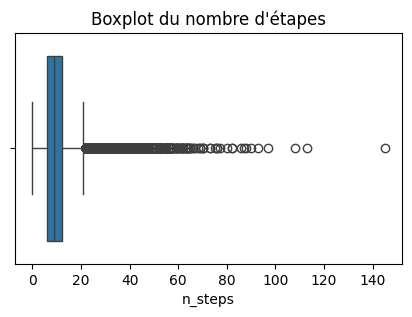

In [4]:
# Afficher la boîte à moustaches pour la variable 'n_steps'
plt.figure(figsize=(5, 3))
sns.boxplot(x='n_steps', data=recipe)
plt.title("Boxplot du nombre d'étapes")
plt.xlabel("n_steps")
plt.show()

Remarque : 
- Beaucoup de recettes ont plus de 20 étapes, ce qui semble excessif. Cela peut être dû à des erreurs dans les données ou à des recettes très complexes.

Faire le tri des outliers

In [ ]:
# Afficher le n_steps minimum, maximum
print("n_steps min:", recipe['n_steps'].min())
print("n_steps max:", recipe['n_steps'].max())
# Afficher le nombre de recettes avec 0 n_steps
print("Nombre de recettes avec 0 n_steps:", recipe[recipe['n_steps'] == 0].shape[0])
# Afficher les instructions de la recette avec 0 n_steps
print("Instructions de la recette avec 0 n_steps:", recipe[recipe['n_steps'] == 0]['steps'].values)
# Afficher les instructions de la recette avec 145 n_steps
print("Instructions de la recette avec 145 n_steps:", recipe[recipe['n_steps'] == 145]['steps'].values)

n_steps min: 0
n_steps max: 145
Nombre de recettes avec 0 n_steps: 1
Instructions de la recette avec 0 n_steps: ['[]']
Instructions de la recette avec 145 n_steps: ["['white bread:', 'lightly spooning flour into measuring cup & leveling off , measure out 2 1 / 2 cups flour', 'combine flour , dry yeast , sugar , & salt in a large mixer bowl', 'blend', 'in a medium saucepan , combine water , milk , and oil', 'heat until very warm', 'add eggs and liquid to flour mixture', 'mixing - blend at low speed until moistened', 'beat 3 minutes at medium speed', 'with a wooden spoon , stir in an additional 3 to 3-1 / 2 cups of flour to form a sticky dough', 'in bowl or on a floured board , gradually work in 1 / 2 to 1-1 / 2 cups more flour , kneading or working in with hands until dough is smooth , pliable and no longer sticky', 'rising - place dough in a greased bowl', 'cover with a cloth or loose fit lid', 'let rise in a warm place until light and double in size , about 45 minutes', 'shaping & bak

Nous allons supprimer la recette avec 0 instruction mais conserver les recettes avec beaucoup d'étape. Comme nous pouvons le voir pour la recette avec 145 étapes, il y a très peu de mots par étape.

In [ ]:
# Supprimer la recette avec 0 n_steps
recipe = recipe[recipe['n_steps'] != 0]
# Sauvegarder le dataset nettoyé
recipe.to_csv("recipe/5_recipe_cleaned_without_0_steps.csv", index=False)
# Charger le dataset nettoyé
recipe = pd.read_csv("recipe/5_recipe_cleaned_without_0_steps.csv")
print(recipe.shape)

(221813, 6)


Plutôt que d'utiliser le nombre d'étapes pour une recette (avec les aberrations que l'on a pu observer), nous pourrions envisager d'utiliser le nombre moyen de mots par étape pour chaque recette comme une mesure plus précise de la complexité des instructions. Cela pourrait mieux refléter l'effort requis pour suivre la recette. En effet, une recette avec moins d'étapes mais des instructions détaillées pourrait être plus complexe qu'une recette avec de nombreuses étapes mais des instructions succinctes.

In [12]:
# Calcul de la moyenne du nombre de mots par étape
def calculate_avg_words_per_step(steps_text):
    """Calcule la moyenne du nombre de mots par étape"""
    try:
        # Convertir la chaîne en liste si nécessaire
        if isinstance(steps_text, str):
            steps_list = ast.literal_eval(steps_text)
        else:
            steps_list = steps_text
            
        # Compter les mots pour chaque étape
        word_counts = [len(step.split()) for step in steps_list]
        
        # Retourner la moyenne
        return np.mean(word_counts) if word_counts else 0
    except:
        return 0

# Appliquer le calcul
recipe['avg_words_per_step'] = recipe['steps'].apply(calculate_avg_words_per_step)

print("Statistiques de la complexité des instructions:")
print(f"  • Moyenne générale: {recipe['avg_words_per_step'].mean():.1f} mots/étape")
print(f"  • Médiane: {recipe['avg_words_per_step'].median():.1f} mots/étape")
print(f"  • Min-Max: {recipe['avg_words_per_step'].min():.1f} - {recipe['avg_words_per_step'].max():.1f}")

Statistiques de la complexité des instructions:
  • Moyenne générale: 10.4 mots/étape
  • Médiane: 10.0 mots/étape
  • Min-Max: 1.0 - 144.0


In [ ]:
# Afficher la moyenne de mots par étape de la recette avec 145 n_steps
print("Moyenne de mots par étape de la recette avec 145 n_steps:", recipe[recipe['n_steps'] == 145]['avg_words_per_step'].values)

Moyenne de mots par étape de la recette avec 145 n_steps: [9.53793103]


Nous pouvons proposer une nouvelle variable qui catégorise les instructions en fonction de la moyenne de mots par étape: Simple, Moyennement complexe, Complexe.

Nous allons pour faire cette catégorisation nous appuyer sur les percentiles (ce qui permet de diviser les données en portions égales basées sur la distribution réelle).

In [ ]:
def categorize_complexity_percentiles(recipe_data):
    """Catégorisation basée sur les percentiles des données"""
    
    # Calculer les seuils basés sur les percentiles
    q33 = recipe_data['avg_words_per_step'].quantile(0.33)
    q67 = recipe_data['avg_words_per_step'].quantile(0.67)
    
    def assign_category(avg_words):
        if avg_words < q33:
            return 'Simple'
        elif q33 <= avg_words < q67:
            return 'Moyennement complexe'
        else:
            return 'Complexe'
    
    # Appliquer la catégorisation avec le nouveau nom
    recipe_data['steps_complexity'] = recipe_data['avg_words_per_step'].apply(assign_category)
    
    print(f"SEUILS CALCULÉS:")
    print(f"   • Simple: < {q33:.1f} mots/étape")
    print(f"   • Moyennement complexe: {q33:.1f} - {q67:.1f} mots/étape")
    print(f"   • Complexe: > {q67:.1f} mots/étape")
    
    return recipe_data

# Appliquer la méthode
recipe = categorize_complexity_percentiles(recipe)

# Vérifier la répartition avec le nouveau nom
complexity_counts = recipe['steps_complexity'].value_counts()
print(f"\nRÉPARTITION RÉSULTANTE:")
for cat, count in complexity_counts.items():
    percentage = (count / len(recipe)) * 100
    print(f"   • {cat}: {count:,} recettes ({percentage:.1f}%)")

SEUILS CALCULÉS:
   • Simple: < 8.7 mots/étape
   • Moyennement complexe: 8.7 - 11.4 mots/étape
   • Complexe: > 11.4 mots/étape

RÉPARTITION RÉSULTANTE:
   • Moyennement complexe: 75,677 recettes (34.1%)
   • Complexe: 73,599 recettes (33.2%)
   • Simple: 72,537 recettes (32.7%)


Nous avons créé deux nouvelles variables : `avg_words_per_step` et `steps_complexity`

A discuter : est ce qu'on estime nous même ce qui est une recette simple, moyenne et complexe ou est-ce que cette variable est défini par nos données et donc chaque catégorie a le même nombre de recette.

In [ ]:
# Sauvegarder le nouveau dataset
#recipe = categorize_complexity_percentiles(recipe)
#recipe.to_csv("recipe/6_recipe_with_steps_complexity.csv", index=False)